# CMS

In [1]:
using DataFramesMeta, CSV, Kroki
dir = pwd() * "/CMS/";

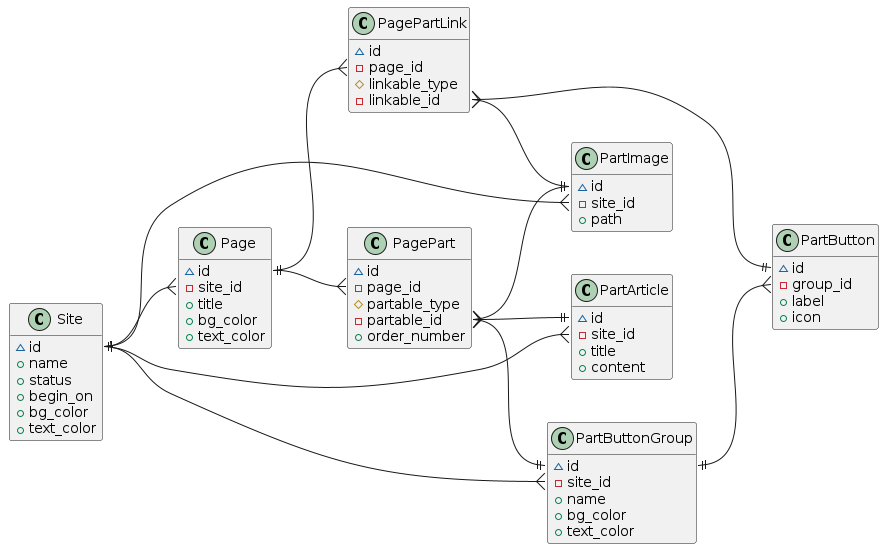

In [2]:
plantuml"""
class Site {
    ~ id
    + name
    + status
    + begin_on
    + bg_color
    + text_color
}
class Page {
    ~ id
    - site_id
    + title
    + bg_color
    + text_color
}
class PagePart {
    ~ id
    - page_id
    # partable_type
    - partable_id
    + order_number
}
class PartArticle {
    ~ id
    - site_id
    + title
    + content
}
class PartImage {
    ~ id
    - site_id
    + path
}
class PartButtonGroup {
    ~ id
    - site_id
    + name
    + bg_color
    + text_color
}
class PartButton {
    ~ id
    - group_id
    + label
    + icon
}
class PagePartLink {
    ~ id
    - page_id
    # linkable_type
    - linkable_id
}
hide methods
left to right direction

Site::id ||--{ Page::site_id
Page::id ||--{ PagePart::page_id
Site::id ||--{ PartArticle::site_id
Site::id ||--{ PartImage::site_id
Site::id ||--{ PartButtonGroup::site_id
PartButtonGroup::id ||--{ PartButton::group_id
PagePart::partable_id }--|| PartArticle::id
PagePart::partable_id }--|| PartImage::id
PagePart::partable_id }--|| PartButtonGroup::id
Page::id ||--{ PagePartLink::page_id
PagePartLink::linkable_id }--|| PartImage::id
PagePartLink::linkable_id }--|| PartButton::id
"""

## Example

In [3]:
# sites
sites = CSV.read(dir * "sites.csv", DataFrame)

Row,id,name,status,begin_on,bg_color,text_color
,Int64,String15,String15,Date,String7,String7
1,1,Corporate,published,2023-07-08,#FFFFFF,#000000
2,2,Campaign,draft,missing,#EFF9F8,#3A3924


In [4]:
# pages
pages = CSV.read(dir * "pages.csv", DataFrame)

Row,id,site_id,title,bg_color,text_color
,Int64,Int64,String15,Missing,Missing
1,1,1,Home,missing,missing
2,2,1,Works,missing,missing
3,3,1,About,missing,missing
4,4,2,Top page,missing,missing


In [5]:
# part_images
part_images = CSV.read(dir * "part_images.csv", DataFrame)

Row,id,site_id,path
,Int64,Int64,String15
1,1,1,logo.png
2,2,1,banner.png


In [6]:
# part_button_groups
part_button_groups = CSV.read(dir * "part_button_groups.csv", DataFrame)

Row,id,site_id,name,bg_color,text_color
,Int64,Int64,String15,String7,String7
1,1,1,Navigation Bar,#E1E2E7,#13141A


In [7]:
# part_buttons
part_buttons = CSV.read(dir * "part_buttons.csv", DataFrame)

Row,id,group_id,label,icon
,Int64,Int64,String7,String15
1,1,1,Works,palette
2,2,1,About,building


In [8]:
# part_articles
part_articles = CSV.read(dir * "part_articles.csv", DataFrame)

Row,id,site_id,title,content
,Int64,Int64,String31,String
1,1,1,私たちが得意なこと,弊社は創業より〇〇に努めて、〇〇
2,2,1,会社案内,資本金 〇〇


In [9]:
# page_part_links
page_part_links = CSV.read(dir * "page_part_links.csv", DataFrame)
page_part_links |> display
@chain page_part_links begin
    innerjoin(select(pages, :id, :title => :link_to_page_title), on= :page_id => :id)
    leftjoin(
        select(
            @transform(part_images, :type = "PartImage"),
            :id, :path => :value1, :type
        ),
        on= [:linkable_id => :id, :linkable_type => :type]
    )
    leftjoin(
        select(
            @transform(part_buttons, :type = "PartButton"),
            :id, :label => :value2, :type
        ),
        on= [:linkable_id => :id, :linkable_type => :type]
    )
    @rtransform(:value = coalesce(:value1, :value2))
    sort(:id)
    select(:id, :linkable_type, :value, :link_to_page_title)
end

Row,id,page_id,linkable_type,linkable_id
,Int64,Int64,String15,Int64
1,1,1,PartImage,1
2,2,2,PartButton,1
3,3,3,PartButton,2


Row,id,linkable_type,value,link_to_page_title
,Int64,String15,InlineSt…,String15
1,1,PartImage,logo.png,Home
2,2,PartButton,Works,Works
3,3,PartButton,About,About


In [10]:
# page_parts
page_parts = CSV.read(dir * "page_parts.csv", DataFrame)
page_parts |> display
@chain page_parts begin
    innerjoin(select(pages, :id, :title => :page_title), on= :page_id => :id)
    leftjoin(
        select(
            @transform(part_images, :type = "PartImage"),
            :id, :path => :value1, :type
        ),
        on= [:partable_id => :id, :partable_type => :type]
    )
    leftjoin(
        select(
            @rtransform(part_button_groups, :type = "PartButtonGroup"),
            :id, :name => :value2, :type
        ),
        on= [:partable_id => :id, :partable_type => :type]
    )
    leftjoin(
        select(
            @rtransform(part_articles, :type = "PartArticle"),
            :id, :title => :value3, :type
        ),
        on= [:partable_id => :id, :partable_type => :type]
    )
    @rtransform(:value = coalesce(:value1, :value2, :value3))
    sort(:id)
    select(:id, :page_title, :partable_type, :value, :order_number)
end

Row,id,page_id,partable_type,partable_id,order_number
,Int64,Int64,String15,Int64,Int64
1,1,1,PartImage,1,1
2,2,1,PartButtonGroup,1,2
3,3,1,PartImage,2,3
4,4,1,PartArticle,1,4
5,5,2,PartImage,1,1
6,6,2,PartButtonGroup,1,2
7,8,2,PartArticle,2,3


Row,id,page_title,partable_type,value,order_number
,Int64,String15,String15,InlineSt…,Int64
1,1,Home,PartImage,logo.png,1
2,2,Home,PartButtonGroup,Navigation Bar,2
3,3,Home,PartImage,banner.png,3
4,4,Home,PartArticle,私たちが得意なこと,4
5,5,Works,PartImage,logo.png,1
6,6,Works,PartButtonGroup,Navigation Bar,2
7,8,Works,PartArticle,会社案内,3
